<a href="https://colab.research.google.com/github/rofiahadeshina/QuickStart2020/blob/master/Task_Rwanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/model_cleanup/scripts/interactive/example_one_bundesland.ipynb)

# **RWANDA** 

In this project we used Bayesian inference technique to estimate the SIR model parameters, and apply Bayesian model comparison to select models that best fit the observed data; Rwanda COVID19 reported cases. The workflow of the project is informed by [this article](https://science.sciencemag.org/content/sci/369/6500/eabb9789.full.pdf) published by a team of researchers in Germany for the German COVID19 cases.

In [2]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git      #cloning the project git repository

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-dy0j_q69
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-dy0j_q69
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=484e197782a24480ca29821e5b9853c0465d14ada6d96331261e1cfb89d53030
  Stored in directory: /tmp/pip-ephem-wheel-cache-cw7sg8n8/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference




#### importing libraries


In [22]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

importing the module we need for the model from the git repository

In [23]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

## Evidence = P(Data|Model)

##      $P(\theta|Data,Model) ~=~ P(Data|\theta,Model)P(\theta)$



## Data retrieval

The next thing we want to do is load a dataset from somewhere.
There are multiple download sources which can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).
In this example we will use the JHU dataset which is the database for covid19 cases in the world being managed by researchers at the John Hopkins University in the United States of America.


In [24]:
jhu = cov19.data_retrieval.JHU()
jhu.download_all_available_data()



INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


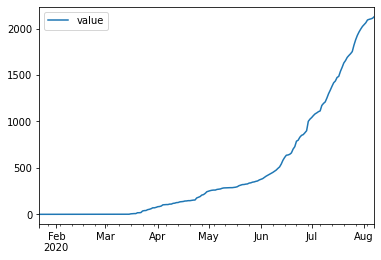

In [25]:
df = jhu.confirmed.Rwanda
df.columns = ['value']
df.plot()

#### Dropping Null Values



In [26]:
df = df.dropna()
df.columns = ['confirmed_cases']
df = df[df['confirmed_cases']>=100]
df

,confirmed_cases
2020-04-04,102
2020-04-05,104
2020-04-06,105
2020-04-07,105
2020-04-08,110
...,...
2020-08-03,2092
2020-08-04,2099
2020-08-05,2104
2020-08-06,2111




We can now access this downloaded data by the attribute
```
jhu.data
```
but normally one would use the build in filter methods,
these can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html#covid19_inference.data_retrieval.JHU.get_new).

Next we retrieve the filtered data from our source in this example we will get all new cases and the total (cumulative) cases the country.


#### Choosing Start Date and End Date time

We chose the start date by noting when the first hundred cases was reported in the country and used it as the start date. We decided to use the end date uptil the present day. 



In [27]:
bd = datetime.datetime(2020, 4, 4)  # For the date filter
ed = datetime.datetime.now()

In [28]:
total_cases_obs = jhu.get_total(
    value="confirmed", country='Rwanda', data_begin=bd, data_end=ed
)
new_cases_obs = jhu.get_new(
    value="confirmed", country='Rwanda', data_begin=bd, data_end=ed
)

total_cases_obs = total_cases_obs[total_cases_obs>100]     #to filter for cases over 100


In [29]:
total_cases_obs[total_cases_obs.isnull()]    # to verify that no null value is present in the dataset

Series([], Name: confirmed, dtype: int64)

In [30]:
new_cases_obs[new_cases_obs.isnull()]     # to verify that no null value is present in the dataset

Series([], Name: confirmed, dtype: int64)

In [31]:
new_cases_obs.head()      #preview of the loaded data with the 5 starting entries

date
2020-04-04    13
2020-04-05     2
2020-04-06     1
2020-04-07     0
2020-04-08     5
Name: confirmed, dtype: int64

#### Splitting into Training and Validating Set

To ensure that after creating the model, we can test for the accuracy, we divided the dataset into a validating set and training set. The training set is to set up the model while the validating set will be used to check for accuracy of the forecast of the the training set.

To put simply:

The Training set includes all dates from the time the community
transmission reaches 100 to July 25 2020.

Validation set includes dates from 25 July 2020 to one final date in
the covid19 cases data.

In [32]:
train_set = new_cases_obs[new_cases_obs.index <= '2020-07-25']
val_set = new_cases_obs[new_cases_obs.index > '2020-07-25']



## Create the model

First we need to set the priors for the change points and other configs.

The number of days for forecast we chose is 10. 

In [33]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 10

#### Choosing Change Points

The three point we chose are:
*   20 April 2020, mandatory wearing of masks
*   30 April 2020, loosed lockdown and instituting an 8pm to 5am curfew, while allowing free movement within each province during the day and hotels, restaurants opened till 7pm;
*    4 May 2020 (contact ban) a gradual easing of lockdown measures was introduced with selected businesses allowed to resume operations while adhering to health guidelines. Domestic movement restrictions were partially relaxed but strict physical distancing measures mandated in public buses. Bars remain closed, and schools will only re-open in September





In [34]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 4, 20)
prior_date_strong_dist_begin = datetime.datetime(2020, 4, 30)
prior_date_contact_ban_begin = datetime.datetime(2020, 5, 4)

In [35]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]



Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.


In [36]:
params_model = dict(
    new_cases_obs=train_set[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=12.9e6, #population of Rwanda
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10



The model is specified in a context. Each function in this context
has access to the model parameters set.


In [37]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  


## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [38]:
trace = pm.sample(model=this_model, tune=500, draws=100, init="advi+adapt_diag")

Only 100 samples in chain.
WARNING  [pymc3] Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 539.94:  10%|▉         | 19099/200000 [02:45<26:04, 115.61it/s]
Convergence achieved at 19100
INFO     [pymc3.variational.inference] Convergence achieved at 19100
Interrupted at 19,099 [9%]: Average Loss = 564.38
INFO     [pymc3.variational.inference] Interrupted at 19,099 [9%]: Average Loss = 564.38
Sequential sampling (2 chains in 1 job)
INFO     [pymc3] Sequential sampling (2 chains in 1 job)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_3, transient_day_2, transient_day_1, lambda_3_log_, lambda_2_log_, lambda_1_log_, lambda_0_log_]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, wee


## Plotting
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the trace.

### Distributions


Possible varnames are :
['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_log_', 'transient_len_2_log_', 'transient_len_3_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


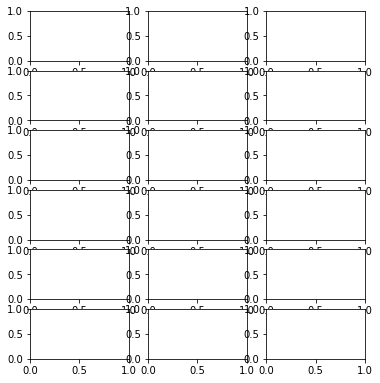

In [39]:
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))
varnames = this_model.untransformed_freeRVs
print("Possible varnames are :")
print(varnames)

In [40]:
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

In [41]:
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

In [42]:
for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

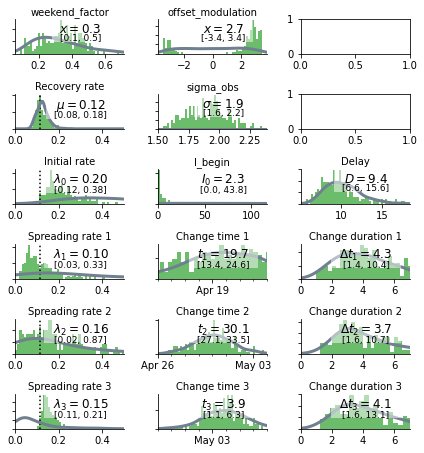

In [43]:
fig.tight_layout()
fig #To print in jupyter notebook

### Timeseries for Train Data
timeseries overview, for now needs an offset variable to get cumulative cases


In [ ]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=-3000)

In [ ]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=total_cases_obs[0])

## Validating Dataset

Using the Validating data to check how accurate the model is by reeastablishng model and using a the whole date range of data collected.

In [44]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 15

In [45]:
params_model = dict(
    new_cases_obs=train_set[:],    ##using the new_cases_obs
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=12.9e6,  #Rwanda's population
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

In [46]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


## MCMC sampling

In [ ]:
trace = pm.sample(model=this_model, tune=500, draws=100, init="advi+adapt_diag")

Only 100 samples in chain.
WARNING  [pymc3] Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 540.45:  10%|▉         | 19398/200000 [02:51<26:32, 113.41it/s]
Convergence achieved at 19400
INFO     [pymc3.variational.inference] Convergence achieved at 19400
Interrupted at 19,399 [9%]: Average Loss = 564.45
INFO     [pymc3.variational.inference] Interrupted at 19,399 [9%]: Average Loss = 564.45
Sequential sampling (2 chains in 1 job)
INFO     [pymc3] Sequential sampling (2 chains in 1 job)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_3, transient_day_2, transient_day_1, lambda_3_log_, lambda_2_log_, lambda_1_log_, lambda_0_log_]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, wee

In [ ]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=-3000)

The forecast of our model does not fit perfectly but it stil gives a reasonable description of what to expect and can be of immense value to government and policy makers. 

